In [25]:
import deepxde as dde
from deepxde.backend import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D

In [26]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.99)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [27]:
def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y * dy_x - 0.01 / np.pi * dy_xx

In [28]:
bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial)

In [29]:
data = dde.data.TimePDE(geomtime, pde, [bc, ic],
                        num_domain=254, num_boundary=8, num_initial=16)

In [30]:
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")

In [31]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)

Compiling model...
'compile' took 0.000587 s



In [32]:
losshistory, train_state = model.train(iterations=30000)

Training model...

Step      Train loss                        Test loss                         Test metric


0         [2.02e-01, 2.32e-01, 2.81e-01]    [2.02e-01, 2.32e-01, 2.81e-01]    []  
1000      [4.24e-02, 1.68e-03, 6.05e-02]    [4.24e-02, 1.68e-03, 6.05e-02]    []  
2000      [2.38e-02, 3.55e-04, 3.36e-02]    [2.38e-02, 3.55e-04, 3.36e-02]    []  
3000      [9.22e-03, 1.94e-04, 1.18e-02]    [9.22e-03, 1.94e-04, 1.18e-02]    []  
4000      [6.13e-03, 1.21e-04, 8.20e-03]    [6.13e-03, 1.21e-04, 8.20e-03]    []  
5000      [4.95e-03, 6.19e-05, 6.48e-03]    [4.95e-03, 6.19e-05, 6.48e-03]    []  
6000      [3.27e-03, 2.82e-05, 4.82e-03]    [3.27e-03, 2.82e-05, 4.82e-03]    []  
7000      [2.57e-03, 2.16e-05, 4.15e-03]    [2.57e-03, 2.16e-05, 4.15e-03]    []  
8000      [2.46e-03, 1.72e-05, 3.60e-03]    [2.46e-03, 1.72e-05, 3.60e-03]    []  
9000      [2.01e-03, 1.75e-05, 3.22e-03]    [2.01e-03, 1.75e-05, 3.22e-03]    []  
10000     [1.68e-03, 1.31e-05, 2.75e-03]    [1.68e-03, 1.31e-05, 2.75e-03]    []  
11000     [5.30e-03, 1.33e-05, 2.36e-03]    [5.30e-03, 1.33e-05, 2.36e-03]    []  
1200

In [33]:
model.compile("L-BFGS-B")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.001629 s

Training model...

Step      Train loss                        Test loss                         Test metric
30000     [5.89e-04, 2.01e-07, 1.30e-03]    [5.89e-04, 2.01e-07, 1.30e-03]    []  

Best model at step 30000:
  train loss: 1.89e-03
  test loss: 1.89e-03
  test metric: []

'train' took 0.015880 s



In [34]:
# dde.optimizers.set_NNCG_options(rank=50, mu=1e-1)
# model.compile("NNCG")
# losshistory, train_state = model.train(iterations=1000, display_every=100)

Saving loss history to c:\Users\A_structure\Coding\bmcs_ml\bmcs_ml\explanatory_notebooks\DeepXDe\loss.dat ...
Saving training data to c:\Users\A_structure\Coding\bmcs_ml\bmcs_ml\explanatory_notebooks\DeepXDe\train.dat ...
Saving test data to c:\Users\A_structure\Coding\bmcs_ml\bmcs_ml\explanatory_notebooks\DeepXDe\test.dat ...


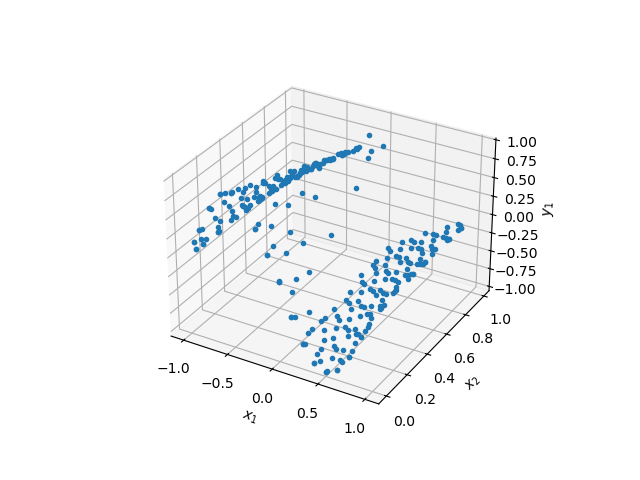

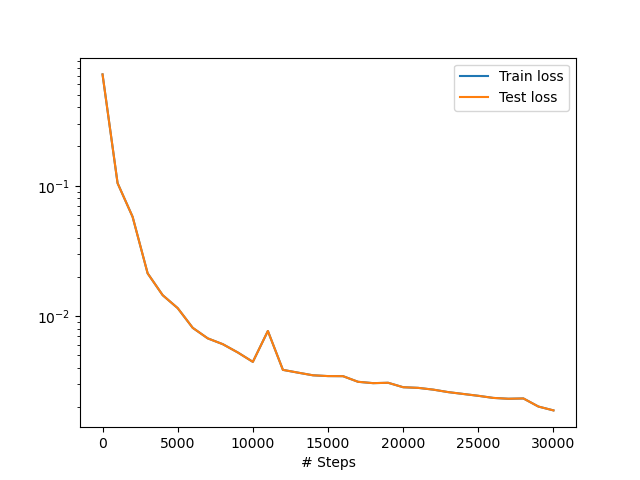

In [35]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


In [36]:
model.save("burgersnet_less_trainingdata")

'burgersnet_less_trainingdata-30000.pt'

In [37]:
model.restore("burgersnet_less_trainingdata-15000.pt")

In [38]:
def gen_testdata():
    data = np.load("../DeepXDe/Burgers.npz")
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y

X, y_true = gen_testdata()


In [39]:
y_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))

Mean residual: 0.17425762
L2 relative error: 0.21666879793917174


c:\Users\A_structure\anaconda3\envs\bmcs_ml\Lib\site-packages\ipympl\backend_nbagg.py:335: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


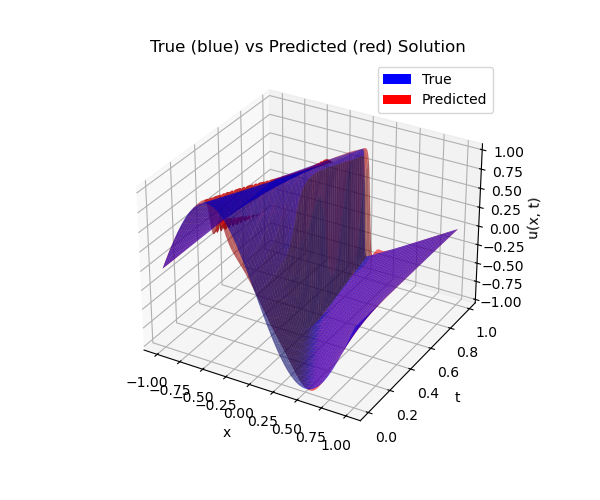

In [40]:
# Reconstruct grids
x_unique = np.unique(X[:, 0])
t_unique = np.unique(X[:, 1])
X_grid, T_grid = np.meshgrid(x_unique, t_unique)

# Reshape true and predicted values to grid shape
Y_true_grid = y_true.reshape(len(t_unique), len(x_unique))
Y_pred_grid = y_pred.reshape(len(t_unique), len(x_unique))

# Plot in one 3D diagram
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

# True solution surface
ax.plot_surface(X_grid, T_grid, Y_true_grid, color='blue', alpha=0.6, label='True')
# Predicted solution surface
ax.plot_surface(X_grid, T_grid, Y_pred_grid, color='red', alpha=0.6, label='Predicted')

# Labels and title
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("u(x, t)")
ax.set_title("True (blue) vs Predicted (red) Solution")

# Matplotlib doesn't handle 3D legends well; work around it
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='blue', label='True'),
    Patch(facecolor='red', label='Predicted')
]
ax.legend(handles=legend_elements)

plt.show()


c:\Users\A_structure\anaconda3\envs\bmcs_ml\Lib\site-packages\matplotlib\animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


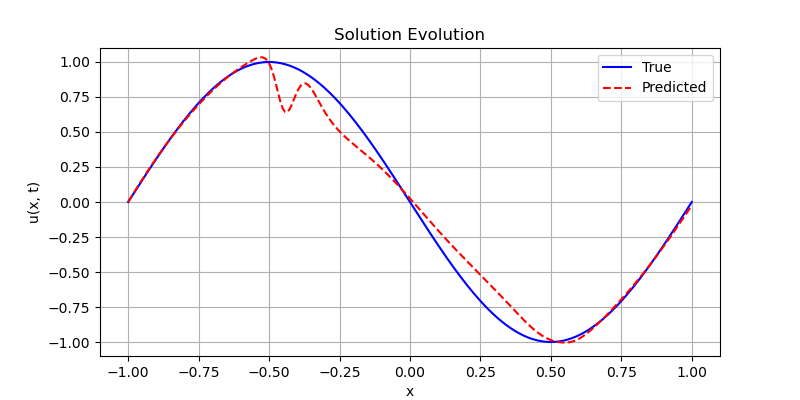

In [42]:
%matplotlib widget

# Reconstruct spatial and temporal grid
x = np.unique(X[:, 0])
t = np.unique(X[:, 1])

# Reshape true and predicted into (nt, nx)
nx = len(x)
nt = len(t)
y_true_plot = y_true.reshape(nt, nx)
y_pred_plot = y_pred.reshape(nt, nx)

# Set up the figure and axis
fig2, ax2 = plt.subplots(figsize=(8, 4))
line_true, = ax2.plot(x, y_true_plot[0], label="True", color='blue')
line_pred, = ax2.plot(x, y_pred_plot[0], label="Predicted", color='red', linestyle='--')
ax2.set_xlabel("x")
ax2.set_ylabel("u(x, t)")
ax2.set_ylim(np.min(y_true_plot) - 0.1, np.max(y_true_plot) + 0.1)
ax2.set_title("Solution Evolution")
ax2.legend()
ax2.grid(True)

# Animation function
def animate(i):
    line_true.set_ydata(y_true_plot[i])
    line_pred.set_ydata(y_pred_plot[i])
    ax2.set_title(f"u(x, t) Evolution | t = {t[i]:.2f}")
    return line_true, line_pred

ani = animation.FuncAnimation(
    fig2, animate, frames=nt, interval=100, blit=False
)

plt.show()
